In [2]:
import os
import numpy as np
import pandas as pd
from pylab import plt, mpl
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
np.set_printoptions(suppress=True, precision=4)
os.environ['PYTHONHASHSEED'] = '0'

#legge i dati e li mette in un DataFrame
url = 'http://hilpisch.com/aiif_eikon_id_eur_usd.csv'
symbol = 'EUR_USD'
raw = pd.read_csv(url, index_col=0, parse_dates=True)
raw.head()

<ipython-input-2-2e9a23ae1e93>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


,HIGH,LOW,OPEN,CLOSE
Date,,,,
2019-10-01 00:00:00,1.0899,1.0897,1.0897,1.0899
2019-10-01 00:01:00,1.0899,1.0896,1.0899,1.0898
2019-10-01 00:02:00,1.0898,1.0896,1.0898,1.0896
2019-10-01 00:03:00,1.0898,1.0896,1.0897,1.0898
2019-10-01 00:04:00,1.0898,1.0896,1.0897,1.0898


In [3]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96526 entries, 2019-10-01 00:00:00 to 2019-12-31 23:06:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HIGH    96526 non-null  float64
 1   LOW     96526 non-null  float64
 2   OPEN    96526 non-null  float64
 3   CLOSE   96526 non-null  float64
dtypes: float64(4)
memory usage: 3.7 MB


In [5]:
#selziona, ricampiona e mostra i prezzi di chiusura
data = pd.DataFrame(raw['CLOSE'].loc[:])
data.columns = [symbol]
data = data.resample('1h', label='right').last().ffill()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2208 entries, 2019-10-01 01:00:00 to 2020-01-01 00:00:00
Freq: H
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   EUR_USD  2208 non-null   float64
dtypes: float64(1)
memory usage: 34.5 KB


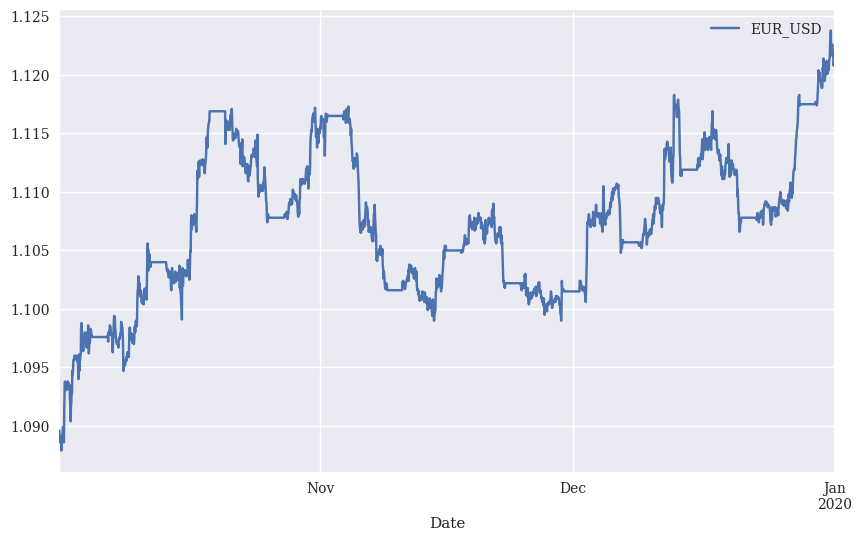

In [6]:
data.plot(figsize=(10, 6));

In [7]:
lags = 5

def add_lags(data, symbol, lags, window=20):  
    cols = []
    df = data.copy()
    df.dropna(inplace=True)
    df['r'] = np.log(df / df.shift())
    df['sma'] = df[symbol].rolling(window).mean()
    df['min'] = df[symbol].rolling(window).min()
    df['max'] = df[symbol].rolling(window).max()
    df['mom'] = df['r'].rolling(window).mean()
    df['vol'] = df['r'].rolling(window).std()
    df.dropna(inplace=True)
    df['d'] = np.where(df['r'] > 0, 1, 0)
    features = [symbol, 'r', 'd', 'sma', 'min', 'max', 'mom', 'vol']
    for f in features:
        for lag in range(1, lags + 1):
            col = f'{f}_lag_{lag}'
            df[col] = df[f].shift(lag)
            cols.append(col)
    df.dropna(inplace=True)
    return df, cols

data, cols = add_lags(data, symbol, lags)

In [8]:
len(data)

2183

In [9]:
#mostra la frequenza delle due classi
c = data['d'].value_counts()  
c

0    1445
1     738
Name: d, dtype: int64

In [10]:
#calcola i pesi appropriati per raggiungere una ponderazione uguale
def cw(df): 
    c0, c1 = np.bincount(df['d'])
    w0 = (1 / c0) * (len(df)) / 2
    w1 = (1 / c1) * (len(df)) / 2
    return {0: w0, 1: w1}

class_weight = cw(data)
class_weight

{0: 0.755363321799308, 1: 1.4789972899728998}

In [11]:
#con i pesi calcolati, entrambe le classi guadagnano lo stesso peso
class_weight[0] * c[0]

1091.5

In [12]:
class_weight[1] * c[1]

1091.5

In [13]:
import random
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score

def set_seeds(seed=100):
    #seme di numeri casuali Python
    random.seed(seed)
    #Numpy seme di numeri casuali
    np.random.seed(seed)
    #TensorFlow seme di numeri casuali
    tf.random.set_seed(seed)

#ottimizzatore predefinito
optimizer = Adam(lr=0.001)

def create_model(hl=1, hu=128, optimizer=optimizer):
    model = Sequential()
    #primo layer
    model.add(Dense(hu, input_dim=len(cols),
                    activation='relu'))  
    for _ in range(hl):
        #livelli aggiuntivi
        model.add(Dense(hu, activation='relu'))
    #livello d'uscita (output)
    model.add(Dense(1, activation='sigmoid'))
    #funzione di perdita, ottimizzatore da utilizzare e metriche aggiuntive da raccogliere
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    return model


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [14]:
#divide l'intero dataset...
split = int(len(data) * 0.8)

#...nel dataset di addestramento...
train = data.iloc[:split].copy()

#...e il set di dati di test.
test = data.iloc[split:].copy()

set_seeds()
model = create_model(hl=1, hu=128)

In [15]:
%%time
h = model.fit(train[cols], train['d'],
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False,
          class_weight=cw(train))

CPU times: user 8.55 s, sys: 478 ms, total: 9.02 s
Wall time: 11.3 s


In [16]:
#valuta le prestazioni nel campione
model.evaluate(train[cols], train['d'])

55/55 [==============================] - 0s 3ms/step - loss: 0.6283 - accuracy: 0.5830


[0.6283310055732727, 0.5830469727516174]

In [17]:
#valuta le prestazioni fuori dal campione
model.evaluate(test[cols], test['d'])

14/14 [==============================] - 0s 3ms/step - loss: 0.6115 - accuracy: 0.6087


[0.6114663481712341, 0.6086956262588501]

In [19]:
test['p'] = np.where(model.predict(test[cols]) > 0.5, 1, 0)
test['p'].value_counts()

14/14 [==============================] - 0s 2ms/step


1    294
0    143
Name: p, dtype: int64

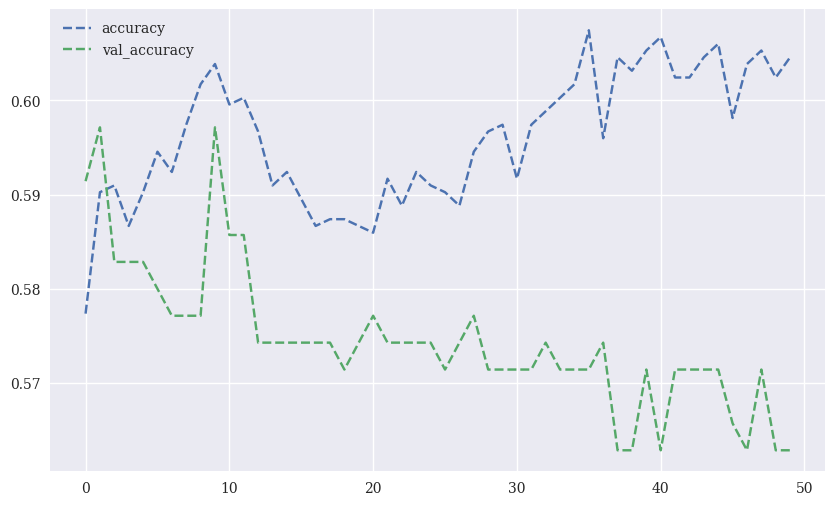

In [20]:
res = pd.DataFrame(h.history)
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

In [22]:
#calcola la media e la deviazione standard per tutte le features di addestramento
mu, std = train.mean(), train.std()

#normalizza il dataset di training in base alla normalizzazione gaussiana
train_ = (train - mu) / std 

set_seeds()
model = create_model(hl=2, hu=128)

h = model.fit(train_[cols], train['d'],
              epochs=50, verbose=False,
              validation_split=0.2, shuffle=False,
              class_weight=cw(train))

In [23]:
#valuta le prestazioni nel campione
model.evaluate(train_[cols], train['d']) 

55/55 [==============================] - 0s 4ms/step - loss: 0.4254 - accuracy: 0.9244


[0.42540428042411804, 0.9243986010551453]

In [24]:
#normalizza il dataset di test in basa alla normalizzazione gaussiana
test_ = (test - mu) / std 

#valuta le prestazioni fuori campione
model.evaluate(test_[cols], test['d'])

14/14 [==============================] - 0s 2ms/step - loss: 1.5305 - accuracy: 0.6659


[1.5304620265960693, 0.6659038662910461]

In [26]:
test['p'] = np.where(model.predict(test_[cols]) > 0.5, 1, 0)
test['p'].value_counts()

14/14 [==============================] - 0s 2ms/step


0    300
1    137
Name: p, dtype: int64

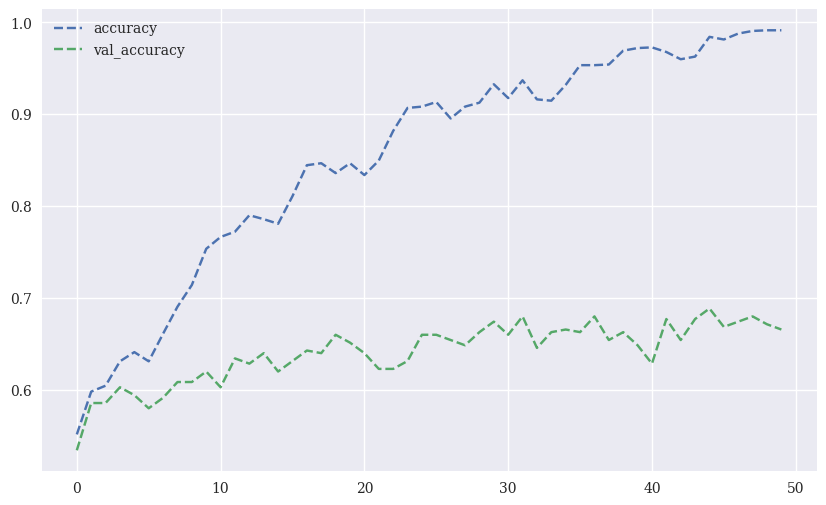

In [27]:
res = pd.DataFrame(h.history)
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

In [29]:
from keras.layers import Dropout

def create_model(hl=1, hu=128, dropout=True, rate=0.3,
                          optimizer=optimizer):
    model = Sequential()
    model.add(Dense(hu, input_dim=len(cols),
                    activation='relu'))
    if dropout:
      #aggiunge dropout dopo ogni strato
       model.add(Dropout(rate, seed=100))  
    for _ in range(hl):
        model.add(Dense(hu, activation='relu'))
        if dropout:
            #aggiunge dropout dopo ogni strato
            model.add(Dropout(rate, seed=100))  
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer,
                  metrics=['accuracy'])
    return model

set_seeds()
model = create_model(hl=1, hu=128, rate=0.3)

h = model.fit(train_[cols], train['d'],
              epochs=50, verbose=False,
              validation_split=0.15, shuffle=False,
              class_weight=cw(train))

model.evaluate(train_[cols], train['d'])

55/55 [==============================] - 0s 2ms/step - loss: 0.4495 - accuracy: 0.7869


[0.44946548342704773, 0.7869415879249573]

In [30]:
model.evaluate(test_[cols], test['d'])

14/14 [==============================] - 0s 4ms/step - loss: 0.5743 - accuracy: 0.6499


[0.5743284821510315, 0.6498855948448181]

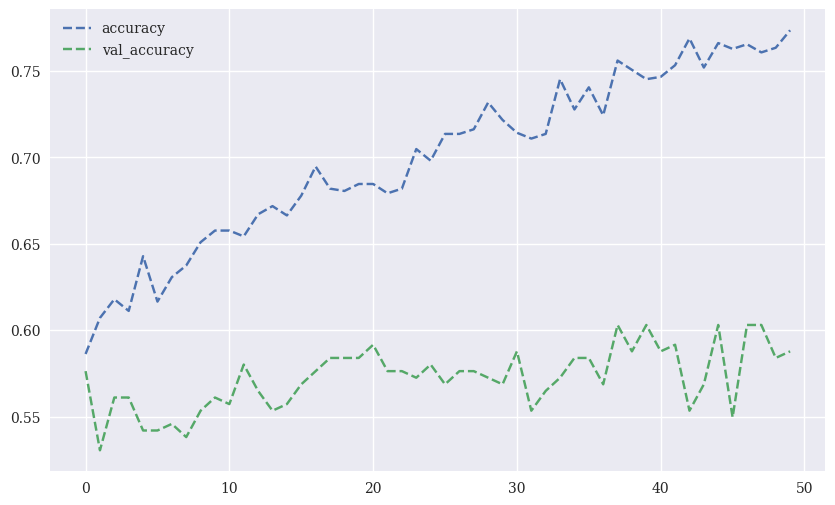

In [31]:
res = pd.DataFrame(h.history)
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

In [35]:
from keras.regularizers import l1, l2
def create_model(hl=1, hu=128, dropout=False, rate=0.3,
                  regularize=False, reg=l1(0.0005),
                  optimizer=optimizer, input_dim=len(cols)):
    if not regularize:
        reg = None
    model = Sequential()
    model.add(Dense(hu, input_dim=input_dim,
                    #la regolarizzazione viene aggiunta a ogni strato
                    activity_regularizer=reg,  
                    activation='relu'))
    if dropout:
        model.add(Dropout(rate, seed=100))
    for _ in range(hl):
        model.add(Dense(hu, activation='relu',
                        activity_regularizer=reg)) 
        if dropout:
            model.add(Dropout(rate, seed=100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer,
                  metrics=['accuracy'])
    return model

set_seeds()
model = create_model(hl=1, hu=128, regularize=True)

h = model.fit(train_[cols], train['d'],
              epochs=50, verbose=False,
              validation_split=0.2, shuffle=False,
              class_weight=cw(train))

model.evaluate(train_[cols], train['d'])

55/55 [==============================] - 0s 3ms/step - loss: 0.3973 - accuracy: 0.8832


[0.3972871005535126, 0.8831614851951599]

In [36]:
model.evaluate(test_[cols], test['d'])

14/14 [==============================] - 0s 2ms/step - loss: 1.0083 - accuracy: 0.6522


[1.0083409547805786, 0.6521739363670349]

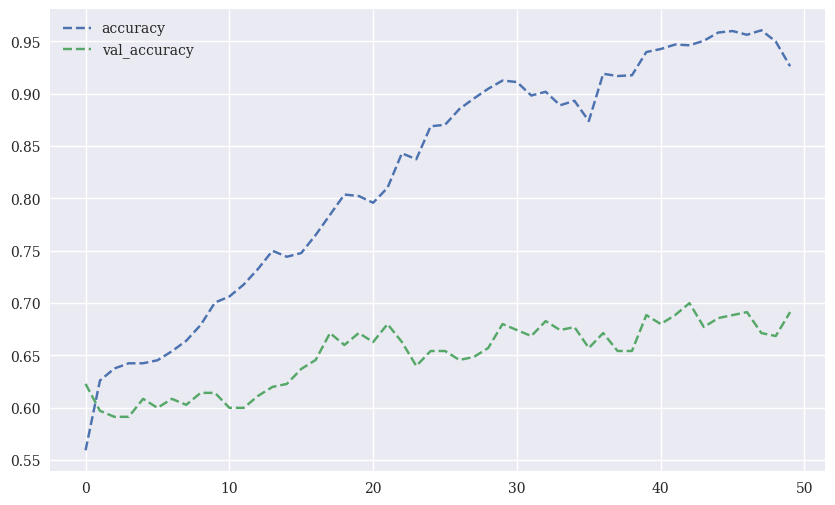

In [37]:
res = pd.DataFrame(h.history)
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

In [38]:
set_seeds()
model = create_model(hl=2, hu=128,
                     #viene aggiunto il dropout al modello
                      dropout=True, rate=0.3,
                     #viene aggiunta la regolarizzazione al modello
                      regularize=True, reg=l2(0.001), 
                      )

h = model.fit(train_[cols], train['d'],
              epochs=50, verbose=False,
              validation_split=0.2, shuffle=False,
              class_weight=cw(train))

In [39]:
model.evaluate(train_[cols], train['d'])

55/55 [==============================] - 0s 3ms/step - loss: 0.4399 - accuracy: 0.7944


[0.4399223327636719, 0.79438716173172]

In [40]:
model.evaluate(test_[cols], test['d'])

14/14 [==============================] - 0s 2ms/step - loss: 0.6080 - accuracy: 0.6430


[0.6080127358436584, 0.6430205702781677]

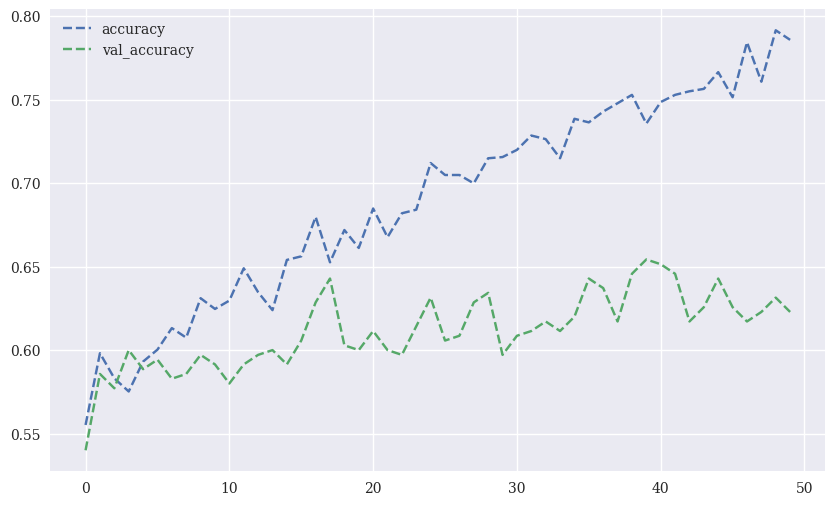

In [41]:
res = pd.DataFrame(h.history)
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

In [42]:
from sklearn.ensemble import BaggingClassifier
from keras.wrappers.scikit_learn import KerasClassifier

max_features = 0.75

set_seeds()
#viene istanziato lo stimatore di base, in questo caso un modello Sequential di Keras
base_estimator = KerasClassifier(build_fn=create_model,
                                 verbose=False, epochs=20, hl=1, hu=128,
                                 dropout=True, regularize=False,
                                 input_dim=int(len(cols) * max_features))

#viene istanziato il modello BaggingClassifier per un numero di stimatori di base uguali
model_bag = BaggingClassifier(base_estimator=base_estimator,
                                   n_estimators=15,
                                   max_samples=0.75,
                                   max_features=max_features,
                                   bootstrap=True,
                                   bootstrap_features=True,
                                   n_jobs=1,
                                   random_state=100,
                                  ) 

model_bag.fit(train_[cols], train['d'])

<ipython-input-42-173b627020b7>:8: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  base_estimator = KerasClassifier(build_fn=create_model,
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


BaggingClassifier(base_estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f17ecee7f40>,
                  bootstrap_features=True, max_features=0.75, max_samples=0.75,
                  n_estimators=15, n_jobs=1, random_state=100)

In [43]:
model_bag.score(train_[cols], train['d'])

55/55 [==============================] - 0s 2ms/step


0.7514318442153494

In [44]:
model_bag.score(test_[cols], test['d'])

14/14 [==============================] - 0s 2ms/step


0.6636155606407322

In [45]:
test['p'] = model_bag.predict(test_[cols])
test['p'].value_counts()

14/14 [==============================] - 0s 2ms/step


0    391
1     46
Name: p, dtype: int64

In [47]:
import time
optimizers = ['sgd', 'rmsprop', 'adagrad', 'adadelta',
              'adam', 'adamax', 'nadam']


for optimizer in optimizers:
    set_seeds()
    #crea un'istanza del modello DNN per l'ottimizzatore specificato
    model = create_model(hl=1, hu=128,
                        dropout=True, rate=0.3,
                        regularize=False, reg=l2(0.001),
                        optimizer=optimizer
                        )  
    t0 = time.time()
    #adatta il modello con l'ottimizzatore dato
    model.fit(train_[cols], train['d'],
              epochs=50, verbose=False,
              validation_split=0.2, shuffle=False,
              class_weight=cw(train)) 
    t1 = time.time()
    t = t1 - t0
    #valuta le prestazioni nel campione
    acc_tr = model.evaluate(train_[cols], train['d'], verbose=False)[1]
    #valuta le prestazioni fuori campione  
    acc_te = model.evaluate(test_[cols], test['d'], verbose=False)[1]  
    out = f'{optimizer:10s} | time[s]: {t:.4f} | in-sample={acc_tr:.4f}'
    out += f' | out-of-sample={acc_te:.4f}'
    print(out)

sgd        | time[s]: 8.8900 | in-sample=0.6346 | out-of-sample=0.6728
rmsprop    | time[s]: 8.5427 | in-sample=0.7703 | out-of-sample=0.6545
adagrad    | time[s]: 8.1901 | in-sample=0.6254 | out-of-sample=0.6613
adadelta   | time[s]: 9.3164 | in-sample=0.3396 | out-of-sample=0.3501
adam       | time[s]: 11.3129 | in-sample=0.7766 | out-of-sample=0.6499
adamax     | time[s]: 11.1541 | in-sample=0.6770 | out-of-sample=0.6293
nadam      | time[s]: 12.2695 | in-sample=0.7852 | out-of-sample=0.6682
